# VIRULENCE FACTORS ANNOTATION

## Virulence factor annotation via BLASTp 

This section builds a local BLAST protein database from the VFDB virulence factor set and screens the *C. rodentium* DEG-associated proteome to identify putative virulence factors by sequence similarity.

Virulence factores list download and protein sequences of full dataset from https://www.mgc.ac.cn/VFs/download.htm - VFDB_setB_pro.fas

In [ ]:
%%bash

# Move to the directory where the virulence-factor protein FASTA and BLAST database will be stored
cd /home/tahila/2504_proj_crodentium/04.virulence_factors/01.PGDB_data/

# 1) Build a local BLAST protein database from the virulence-factor reference FASTA
#    -dbtype prot: protein database
#    -out pgdb: prefix/name for the generated BLAST database files
makeblastdb \
  -in /home/tahila/2504_proj_crodentium/04.virulence_factors/01.PGDB_data/PGDB_setB_pro.fas \
  -dbtype prot \
  -out pgdb

# 2) Define paths for the query proteome (C. rodentium proteins) and output directory
FASTA_CRODENTIUM="/home/tahila/2504_proj_crodentium/00.dados_vindos_deles/CR/CR/GCF_000835925.1_ASM83592v1_protein.faa"
OUTPUT_DIR="/home/tahila/2504_proj_crodentium/04.virulence_factors"

# 3) Run BLASTp: query C. rodentium proteins against the virulence-factor database
#    Output is a tab-separated file (outfmt 6) with key alignment metrics:
#    qseqid (query ID), sseqid (subject ID), pident, length, evalue, bitscore, stitle (full subject title/annotation)
blastp \
  -query "$FASTA_CRODENTIUM" \
  -db pgdb \
  -out "$OUTPUT_DIR"/Vir_factor_blastp_crodentium.tsv \
  -evalue 1e-5 \
  -outfmt "6 qseqid sseqid pident length evalue bitscore stitle"




In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### BLASTp data preprocessing

In [ ]:
# Load BLASTp hits (no header in the TSV output from outfmt 6)
vir_factors = pd.read_csv(
    "/home/tahila/2504_proj_crodentium/04.virulence_factors/Vir_factor_blastp_crodentium.tsv",
    sep="\t",
    header=None
)

# Assign column names matching the BLAST outfmt fields
vir_factors.columns = ["WP ID", "PGG ID", "pident", "length", "evalue", "bitscore", "stitle"]

# Filter hits to retain only confident matches
# - pident >= 50% to keep reasonably similar sequences
vir_factors = vir_factors[vir_factors["pident"] >= 50]

# - evalue <= 1e-5 to keep statistically significant alignments
vir_factors = vir_factors[vir_factors["evalue"] <= 1e-5]

# Quick sanity check of the filtered table
vir_factors.head(3)

,WP ID,VFG ID,pident,length,evalue,bitscore,stitle
143,WP_000031695.1,VFG046459(gb|WP_004287053),86.111,108,1.000000e-64,200.0,VFG046459(gb|WP_004287053) (tufA) elongation f...
144,WP_000031695.1,VFG046474(gb|WP_014714676),86.111,108,1.120000e-64,200.0,VFG046474(gb|WP_014714676) (tufA) elongation f...
145,WP_000031695.1,VFG046458(gb|WP_003024794),85.185,108,1.090000e-63,197.0,VFG046458(gb|WP_003024794) (tufA) elongation f...


In [24]:
len(vir_factors)

3410

### WP IDs data preprocessing

In [ ]:
## FILE WITH WP IDs
def Import_WP_IDs(input_file):
    """
    Import a mapping table linking DEG locus tags to NCBI WP protein IDs.
    Returns: pd.DataFrame with standardized gene–protein mappings.
    """
    # Reads a CSV with 'Locus Tag' and 'WP ID'
    wp_ids = pd.read_csv(input_file)

    # Removes the 'TA05_' prefix from locus tags
    wp_ids["Locus Tag"] = wp_ids["Locus Tag"].str.replace("TA05_", "", regex=False)

    # Renames 'Locus Tag' to 'Gene' for consistency with DEG tables
    wp_ids = wp_ids.rename(columns={"Locus Tag": "Gene"})
    
    return wp_ids

# Load WP ID mappings for upregulated and downregulated DEGs
wp_ids_up = Import_WP_IDs("Locus_Tags_with_WP_IDs_up.csv")
wp_ids_down = Import_WP_IDs("Locus_Tags_with_WP_IDs_down.csv")

# Merge both tables into a single mapping (outer join keeps all genes from both directions)
wp_ids = pd.merge(wp_ids_down, wp_ids_up, on=['Gene', 'WP ID'], how='outer')

wp_ids.head(3)


,Gene,WP ID
0,RS00005,WP_012904980.1
1,RS00010,WP_024132539.1
2,RS00015,WP_012904982.1


### DEGs data preprocessing and WP IDs mapping

In [ ]:
def importDEGStable(tab_degs_path, sheet_name, log2fc_threshold=1):
    """
    Import and preprocess a DEG table, harmonizing gene identifiers and
    linking genes to NCBI WP protein accessions, according to the WP IDs table.

    - Map gene locus tags to WP IDs.
    """

    # Load DEG table from the specified Excel sheet
    tab_degs = pd.read_excel(tab_degs_path, index_col=0, sheet_name=sheet_name)

    # Rename unnamed annotation column for consistency
    tab_degs.rename(columns={'Unnamed: 1': 'Annotation'}, inplace=True)

    # Remove genes without statistical information
    tab_degs = tab_degs.dropna(subset=['log2FoldChange', 'padj'])

    # Standardize gene identifiers by removing locus tag prefix
    tab_degs["Gene"] = tab_degs["Gene"].str.replace("TA05_", "", regex=False)

    # Apply statistical significance filters
    tab_degs = tab_degs[tab_degs['padj'] < 0.05]
    tab_degs = tab_degs[tab_degs['log2FoldChange'].abs() > log2fc_threshold]

    # Merge DEG table with WP ID mapping
    tab_degs_merged = pd.merge(tab_degs, wp_ids, on='Gene')

    # Keep only relevant columns for downstream analysis
    tab_degs_merged = tab_degs_merged[['WP ID', 'Gene', 'log2FoldChange', 'padj', 'Annotation']]

    return tab_degs_merged


tab_degs_path = '/home/tahila/2504_proj_crodentium/diffexpr-results_original.xlsx'

# Import DEG tables (all, upregulated, and downregulated genes)
tab_degs_all = importDEGStable(tab_degs_path, sheet_name='diffexpr-results')
tab_degs_up = importDEGStable(tab_degs_path, sheet_name='UP (padj<0.05, LFC>1)')
tab_degs_down = importDEGStable(tab_degs_path, sheet_name='down (padj<0.05, LFC>1)')

tab_degs_all.head(3)

,WP ID,Gene,log2FoldChange,padj,Annotation
0,WP_012906331.1,RS09845,4.811068,7.181718e-16,propanediol utilization microcompartment prote...
1,WP_012907103.1,RS10235,4.810700,7.866238e-11,type III secretion system needle filament subu...
2,WP_012907102.1,RS10240,4.670672,1.401668e-10,EscG/YscG/SsaH family type III secretion syste...


### Filter DEGs by VF

In [ ]:
def VFBestHit(vf_degs):
    """
    Select the most relevant virulence factor annotation per protein (WP ID)
    based on BLAST ranking criteria.

    Ranking priority (in order):
    1) lowest e-value
    2) highest percent identity (pident)
    3) highest bitscore
    """

    # Sort BLAST hits per WP ID according to the ranking criteria
    df_sorted = vf_degs.sort_values(
        by=['WP ID', 'evalue', 'pident', 'bitscore'],
        ascending=[True, True, False, False]
    )

    # Keep only the best hit per WP ID
    df_best_hits = df_sorted.drop_duplicates(
        subset='WP ID', keep='first'
    ).reset_index(drop=True)

    # Extract virulence gene name from VFG annotation
    df_best_hits['VF_gene_name'] = df_best_hits['VFG_Annotation'].str.extract(
        r'\)\s+\(([^)]+)\)'
    )

    # Extract virulence product description
    df_best_hits['VF_product'] = df_best_hits['VFG_Annotation'].str.extract(
        r'\)\s+\([^)]+\)\s+(.+?)\s+\['
    )

    return df_best_hits


def FilterVF(tab_degs, vir_factors):
    """
    Identify virulence factors among DEGs by intersecting DEG tables with
    BLASTp results against the VF database, selecting the best hit per protein,
    and generating informative labels for visualization.
    """

    # Intersect DEGs with virulence factor BLAST hits
    vir_factors_degs = pd.merge(tab_degs, vir_factors, on='WP ID')
    vir_factors_degs.rename(columns={'stitle': 'VFG_Annotation'}, inplace=True)

    # Select best BLAST hit per WP ID
    vf_degs = VFBestHit(vir_factors_degs)

    # Keep relevant columns for downstream analysis
    vf_degs = vf_degs[
        ['WP ID', 'Gene', 'log2FoldChange', 'padj', 'Annotation',
         'VF_gene_name', 'VF_product', 'VFG ID', 'pident', 'length',
         'evalue', 'bitscore', 'VFG_Annotation']
    ]

    # Extract functional subcategory from VFG annotation (if present)
    def extrair_subcategoria(vfg_annotation):
        match = re.search(
            r'\[(.*?) \(VF\d+\) - (.*?) \(VFC\d+\)\]', vfg_annotation
        )
        if match:
            return match.group(2)
        return ""

    # Generate plot labels with conditional annotation logic
    def gerar_plot_name(row):
        vf_hypo = 'hypothetical protein' in row['VF_product']
        ann_hypo = 'hypothetical protein' in row['Annotation']

        if vf_hypo and not ann_hypo:
            return f"{row['Gene']} ({row['VF_gene_name']}) {row['VF_product']} - {row['Annotation']}"
        elif vf_hypo and ann_hypo:
            subcat = extrair_subcategoria(row['VFG_Annotation'])
            return f"{row['Gene']} ({row['VF_gene_name']}) {row['VF_product']} - {subcat}"
        else:
            return f"{row['Gene']} ({row['VF_gene_name']}) {row['VF_product']}"

    vf_degs['Plot_names'] = vf_degs.apply(gerar_plot_name, axis=1)

    # Rank genes by absolute log2 fold-change
    vf_degs = vf_degs.sort_values(
        by='log2FoldChange', key=abs, ascending=False
    ).reset_index(drop=True)

    return vf_degs


In [ ]:
vf_degs_up = FilterVF(tab_degs_up, vir_factors)
vf_degs_down = FilterVF(tab_degs_down, vir_factors)
vf_degs_all = FilterVF(tab_degs_all, vir_factors)

vf_degs_all.head(3)

,WP ID,Gene,log2FoldChange,padj,Annotation,VF_gene_name,VF_product,VFG ID,pident,length,evalue,bitscore,VFG_Annotation,Plot_names
0,WP_012907103.1,RS10235,4.810700,7.866238e-11,type III secretion system needle filament subu...,sctF,type III secretion system needle filament subu...,VFG041560(gb|WP_012907103),100.0,73,3.020000e-48,146.0,VFG041560(gb|WP_012907103) (sctF) type III sec...,RS10235 (sctF) type III secretion system needl...
1,WP_012907102.1,RS10240,4.670672,1.401668e-10,EscG/YscG/SsaH family type III secretion syste...,ROD_RS14650,EscG/YscG/SsaH family type III secretion syste...,VFG041562(gb|WP_012907102),100.0,98,9.050000e-69,200.0,VFG041562(gb|WP_012907102) (ROD_RS14650) EscG/...,RS10240 (ROD_RS14650) EscG/YscG/SsaH family ty...
2,WP_012907117.1,RS10155,4.661208,6.782228e-04,DUF1106 domain-containing protein,ROD_RS14735,DUF1106 domain-containing protein,VFG041548(gb|WP_012907117),100.0,138,6.850000e-100,282.0,VFG041548(gb|WP_012907117) (ROD_RS14735) DUF11...,RS10155 (ROD_RS14735) DUF1106 domain-containin...


## HEATMAP WITH DIFFERENTIALLY EXPRESSED DEGs

In [ ]:
def PlotHeatmap_PG(
    pg_degs,
    title="",
    name_col="Plot_names",
    log2FC_col="log2FoldChange",
    col_name="log2FoldChange",
    top_n=None,
    x_rotation=0,
    ax=None,
    save=False
):
    """
    Plot a single-column heatmap showing log2 fold-change values for selected genes.

    Genes are ordered by absolute log2 fold-change, and optionally restricted
    to the top_n most strongly regulated genes.
    """

    # Create a new figure/axis if none is provided
    if ax is None:
        n_genes = top_n if top_n is not None else len(pg_degs)
        fig, ax = plt.subplots(
            figsize=(6, max(2, n_genes * 0.4))
        )

    # Check required columns
    if name_col not in pg_degs.columns or log2FC_col not in pg_degs.columns:
        raise ValueError(
            f"Required columns '{name_col}' and/or '{log2FC_col}' not found in DataFrame."
        )

    # Select and rename columns for plotting
    heatmap_df = pg_degs[[name_col, log2FC_col]].copy()
    heatmap_df.columns = ['gene_label', col_name]

    # Order genes by absolute log2FC
    heatmap_df['abs_val'] = heatmap_df[col_name].abs()
    heatmap_df = (
        heatmap_df
        .sort_values(by='abs_val', ascending=False)
        .drop(columns='abs_val')
    )

    # Keep only the top_n genes if specified
    if top_n is not None:
        heatmap_df = heatmap_df.head(top_n)

    # Set gene labels as index for heatmap
    heatmap_df.set_index('gene_label', inplace=True)

    # Plot heatmap
    sns.heatmap(
        heatmap_df,
        cmap="RdBu_r",
        center=0,
        linewidths=0.3,
        linecolor="gray",
        cbar_kws={"label": "log2FoldChange"},
        ax=ax
    )

    # Aesthetic adjustments
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=x_rotation)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    # Optional file export
    if save:
        plt.savefig(save, dpi=300, bbox_inches='tight')

    return heatmap_df


/tmp/ipykernel_409818/1012517581.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_409818/1012517581.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


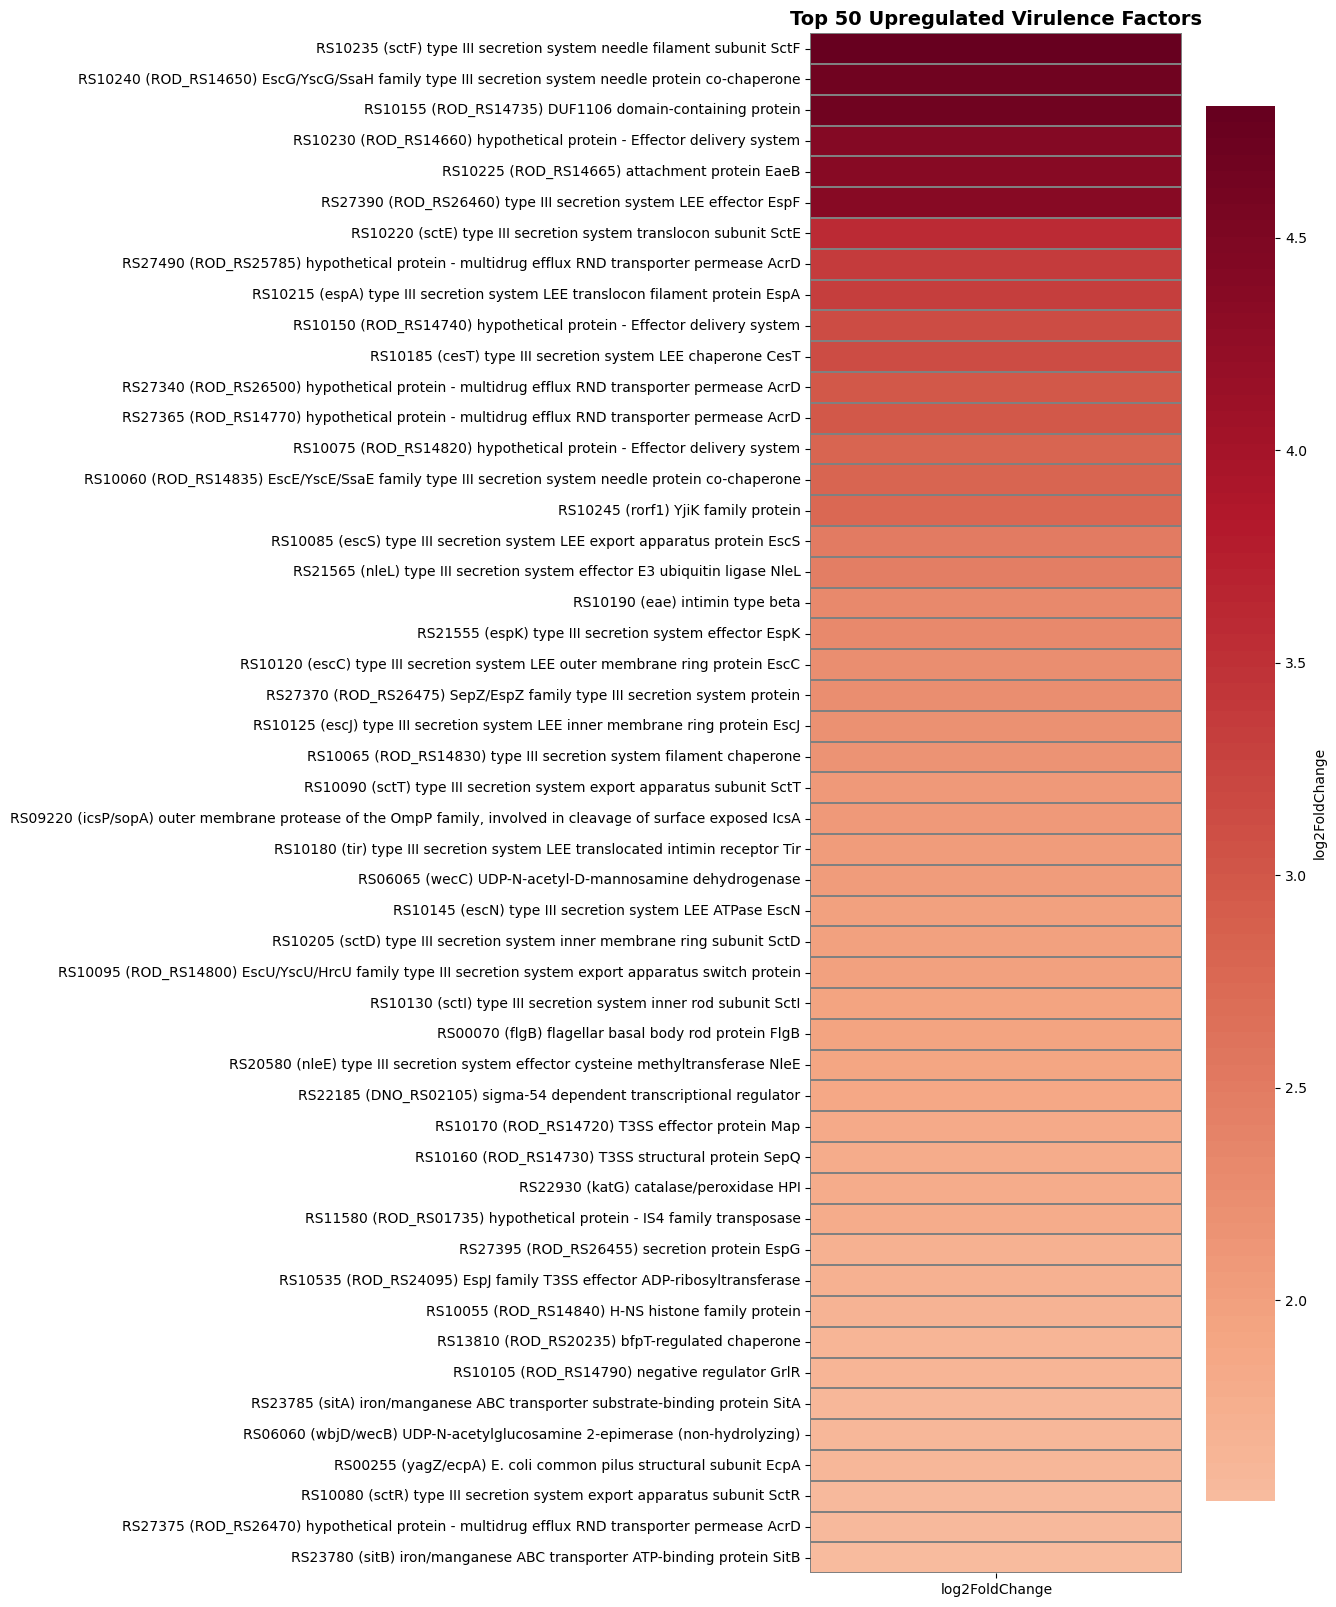

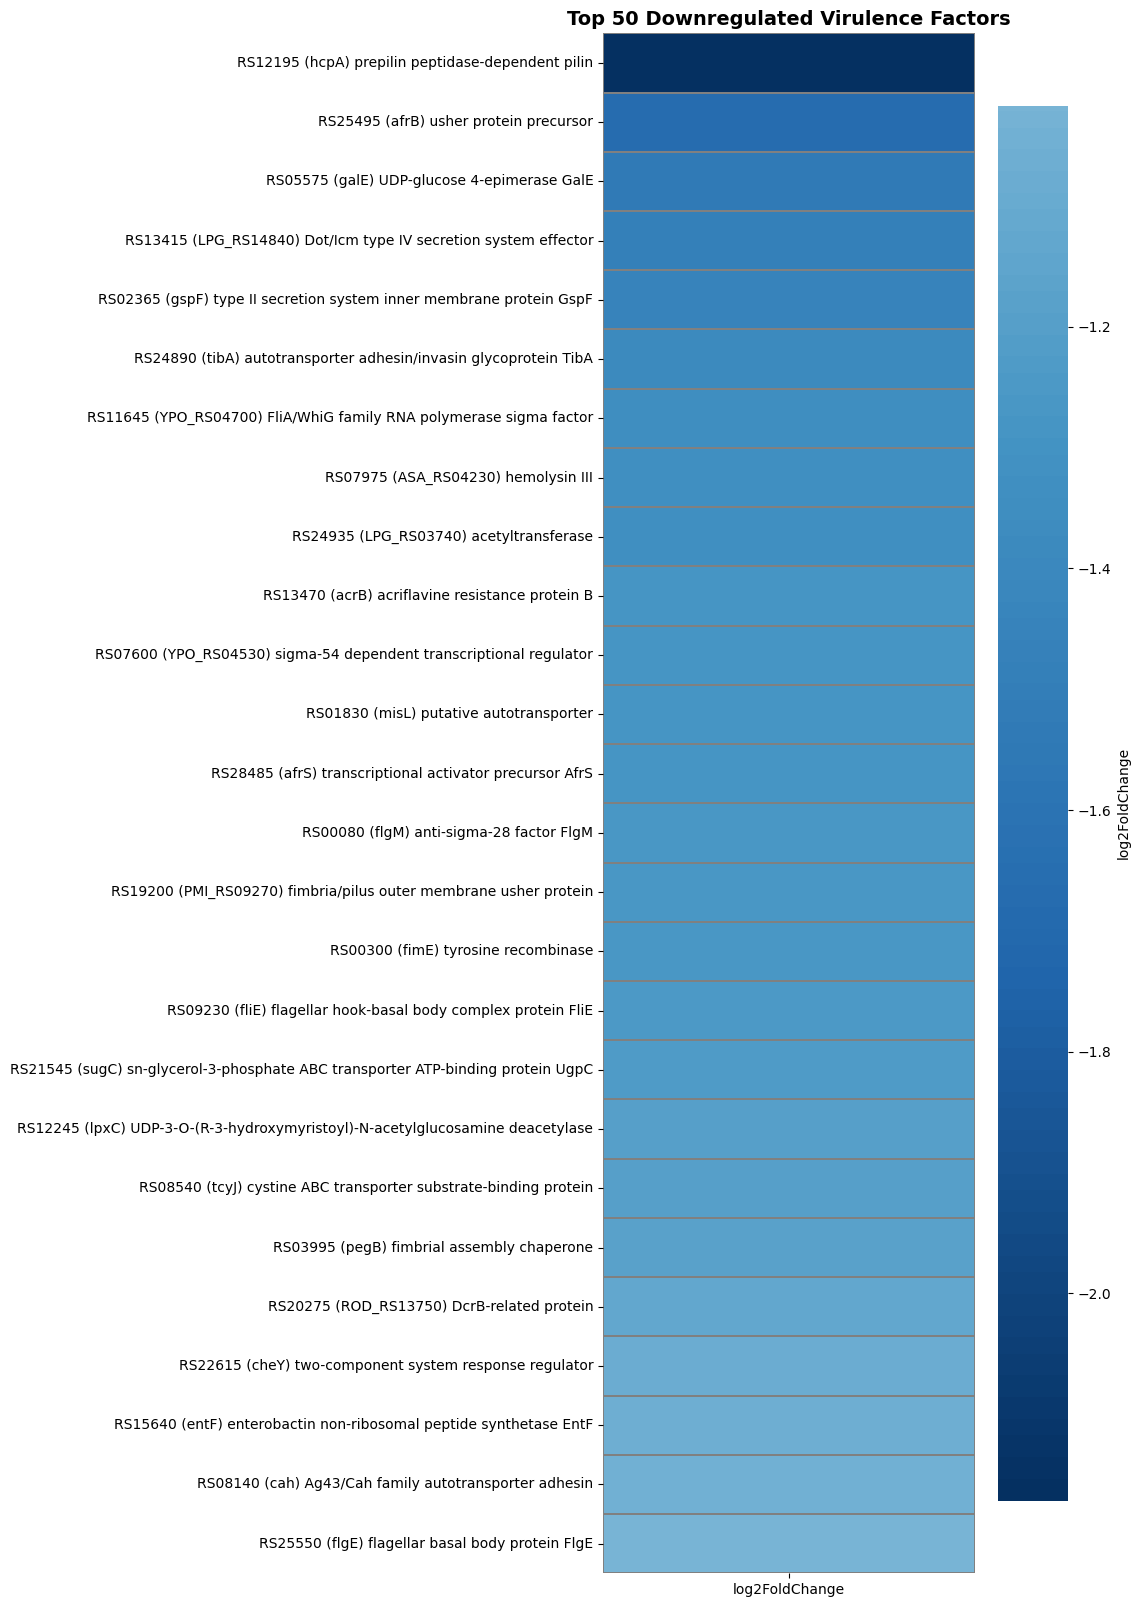

In [ ]:
heatmap_df_up = PlotHeatmap_PG(pg_degs_up, title="Top 50 Upregulated Virulence Factors", top_n=50, save="/home/tahila/2504_proj_crodentium/04.virulence_factors/heatmap_top50_PG_up.png")
heatmap_down = PlotHeatmap_PG(pg_degs_down, title="Top 50 Downregulated Virulence Factors", top_n=50, save="/home/tahila/2504_proj_crodentium/04.virulence_factors/heatmap_top50_PG_down.png")

/tmp/ipykernel_409818/1012517581.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


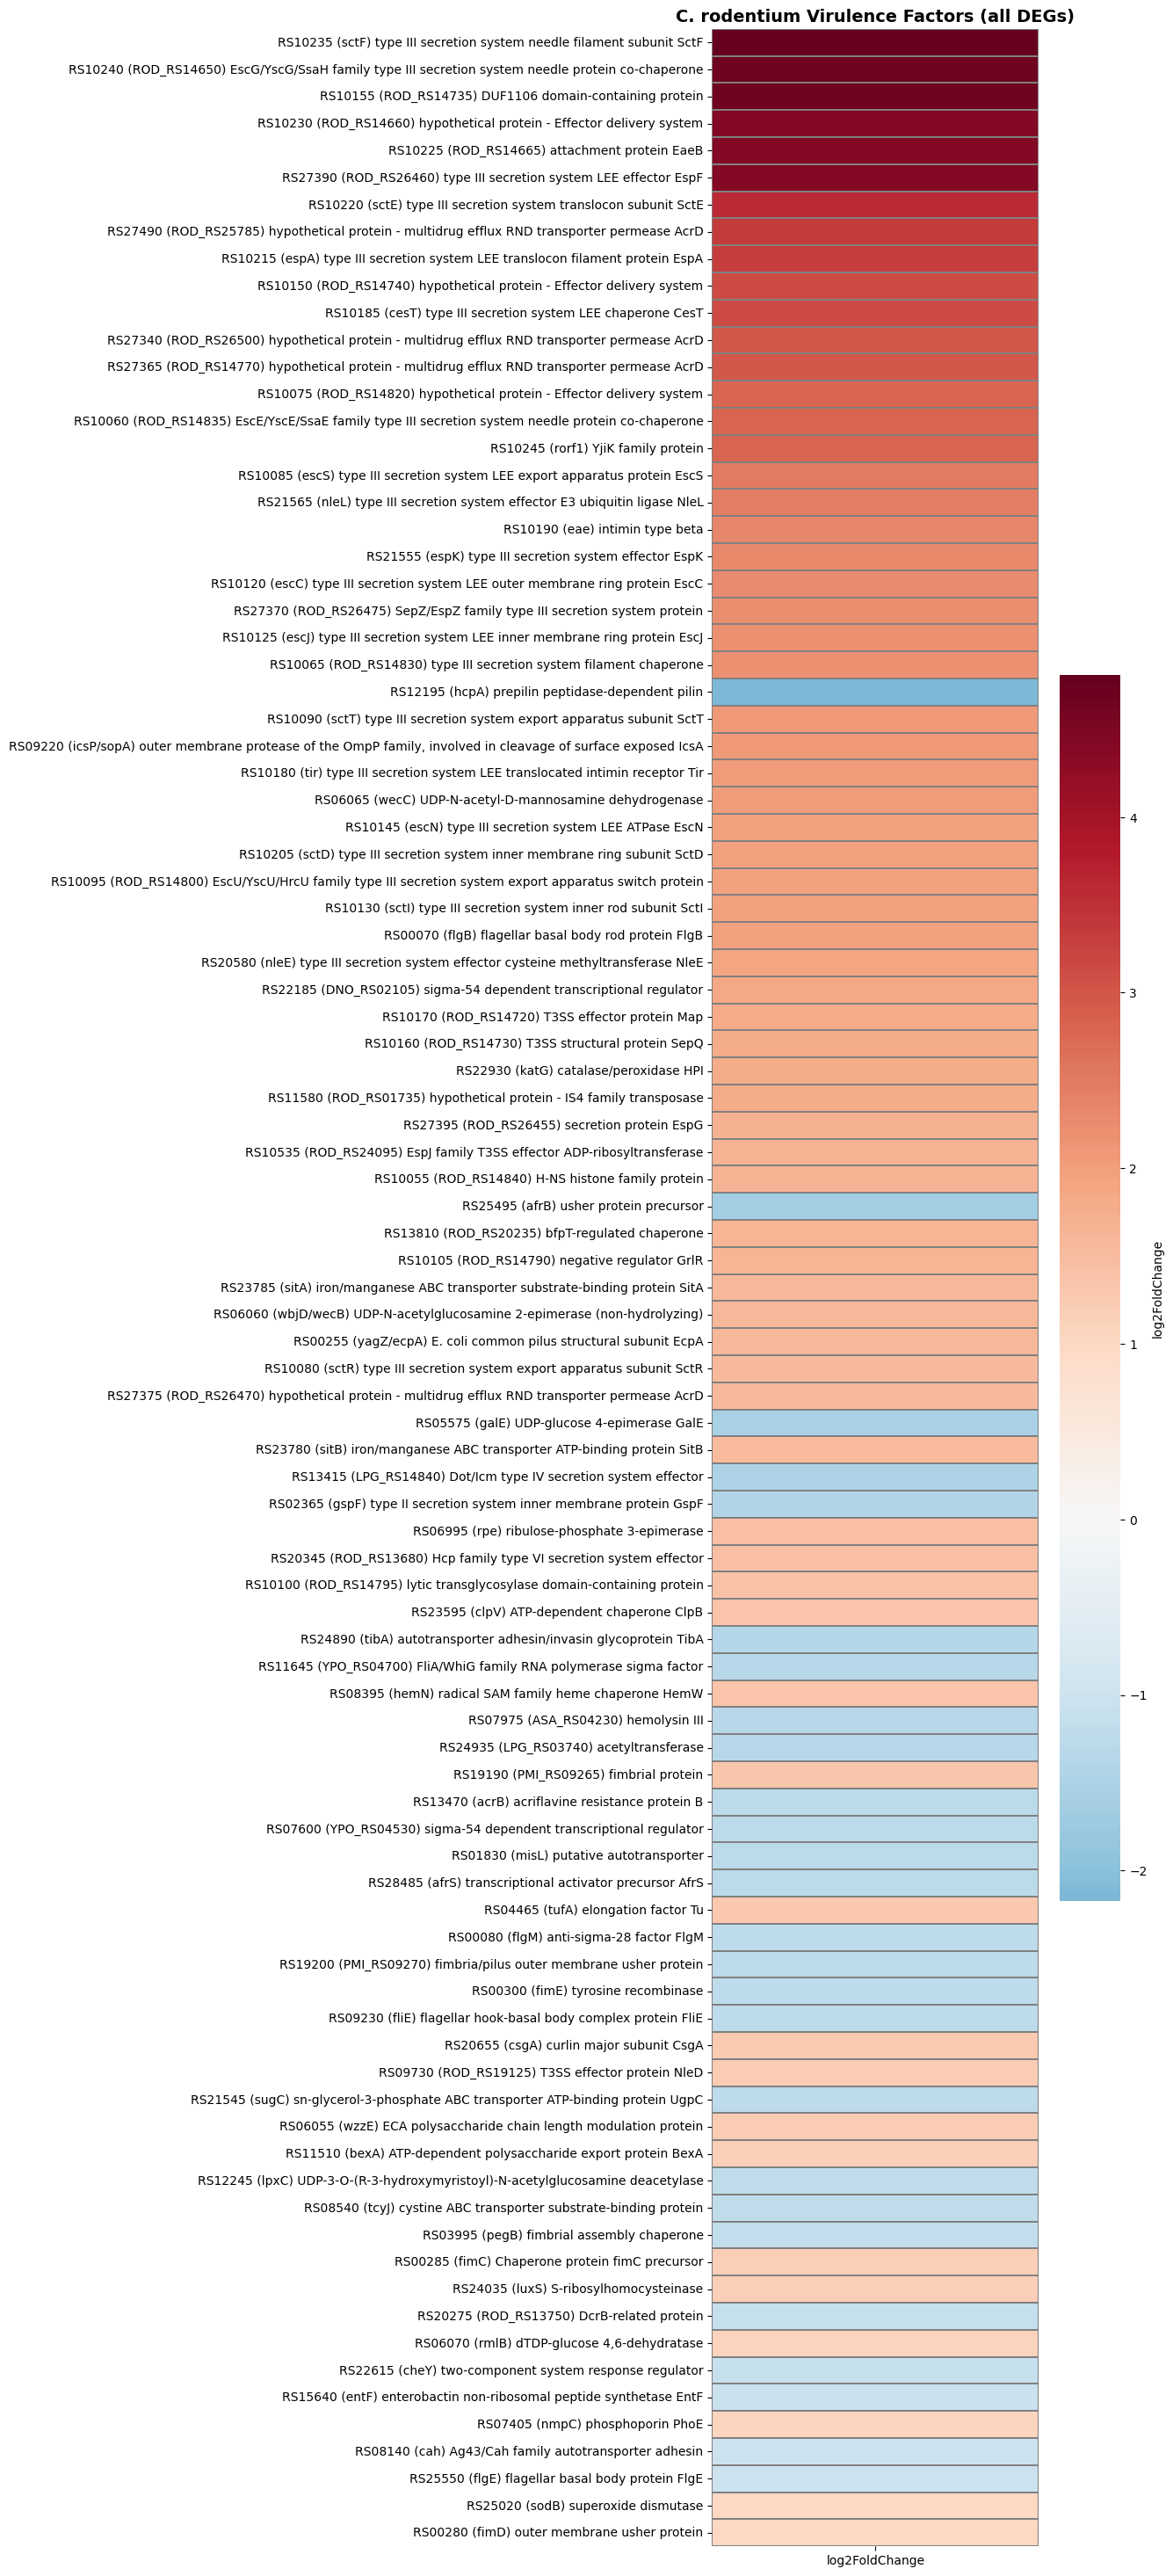

In [ ]:
heatmap_df_all = PlotHeatmap_PG(pg_degs_all, title="C. rodentium Virulence Factors (all DEGs)", save="/home/tahila/2504_proj_crodentium/04.virulence_factors/heatmap_all_PG.png")
